In [1]:
#%%capture
#%pip install optuna
#!git clone https://github.com/rossetl/NNDL.git
#%cd NNDL/Homework\ 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import torch.nn.functional as F
import optuna

/home/lorenzo.rosset/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))])
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False, transform=transform)
full_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [50000, 10000])

train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.Dropout(dropout),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        conc_out.append(decoded_data.cpu())
        conc_label.append(image_batch.cpu())
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    train_loss = loss_fn(conc_out, conc_label)
    return train_loss.data

def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [7]:
torch.manual_seed(0)

encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=2, dropout=0)
decoder = Decoder(encoded_space_dim=2, dropout=0)

In [8]:
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [9]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), 'parameters/encoder0_params.pth')
torch.save(decoder.state_dict(), 'parameters/decoder0_params.pth')

EPOCH 1/50: TRAIN - loss: 0.079051 || VALIDATION - loss: 0.044132
EPOCH 2/50: TRAIN - loss: 0.037986 || VALIDATION - loss: 0.034542
EPOCH 3/50: TRAIN - loss: 0.032869 || VALIDATION - loss: 0.031471
EPOCH 4/50: TRAIN - loss: 0.030855 || VALIDATION - loss: 0.030169


KeyboardInterrupt: 

In [12]:
encoder.load_state_dict(torch.load('parameters/encoder0_params.pth'))
decoder.load_state_dict(torch.load('parameters/decoder0_params.pth'))
encoder.eval()
decoder.eval()

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

Batch normalization leads to better performances, although it slows down the training

In [18]:
results0_df = pd.read_csv('parameters/results0.csv')
train_log = results0_df['loss_curve']
val_log = results0_df['val_curve']

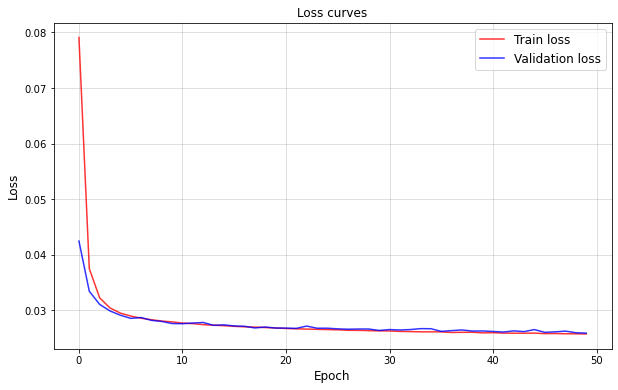

In [19]:
plt.figure(figsize=(10,6))
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [14]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:04<00:00, 2236.29it/s]


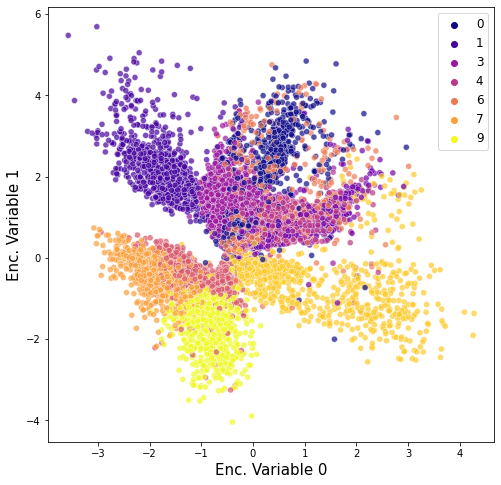

In [15]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('Enc. Variable 0', size=15)
ax.set_ylabel('Enc. Variable 1', size=15);

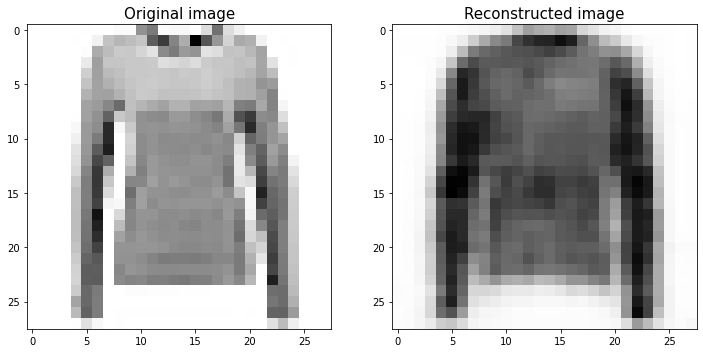

In [ ]:
# Image reconstruction
idx = 1
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

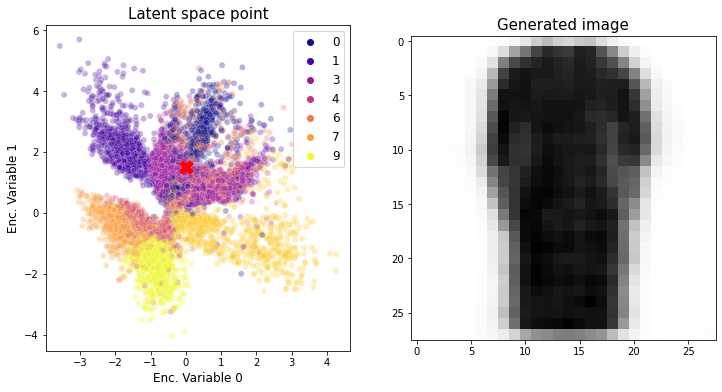

In [16]:
# Generating new images
ls_point = [0, 1.5]
encoded_sample = torch.Tensor(ls_point).unsqueeze_(0).to(DEVICE)
decoder.eval()
with torch.no_grad():
    decoded_sample = decoder(encoded_sample)

encoded_sample = encoded_sample.to('cpu').squeeze().numpy()
decoded_sample = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax[0],
                alpha=0.3,
                palette='plasma')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Enc. Variable 0', size=12)
ax[0].set_ylabel('Enc. Variable 1', size=12);
ax[0].scatter(*ls_point, s=180, color='red', marker='X')
ax[0].set_title('Latent space point', size=15)
ax[1].imshow(decoded_sample, cmap='Greys')
ax[1].set_title('Generated image', size=15);

In [ ]:
# Save results
results0 = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results0.to_csv('results0.csv')

## Optimizers and regularization methods

Adding dropout

In [21]:
torch.manual_seed(0)

encoded_space_dim = 2
p_dropout = 0.2
encoder = Encoder(encoded_space_dim=2, dropout=p_dropout)
decoder = Decoder(encoded_space_dim=2, dropout=p_dropout)

loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=0)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [24]:
results_df = pd.read_csv(f'parameters/results{p_dropout}.csv')
train_log = results_df['loss_curve']
val_log = results_df['val_curve']

encoder.load_state_dict(torch.load(f'parameters/encoder{p_dropout}_params.pth'))
decoder.load_state_dict(torch.load(f'parameters/decoder{p_dropout}_params.pth'))
encoder.eval()
decoder.eval()

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), f'encoder{p_dropout}_params.pth')
torch.save(decoder.state_dict(), f'decoder{p_dropout}_params.pth')

EPOCH 1/50: TRAIN - loss: 0.083531 || VALIDATION - loss: 0.043569
EPOCH 2/50: TRAIN - loss: 0.043841 || VALIDATION - loss: 0.036405
EPOCH 3/50: TRAIN - loss: 0.038796 || VALIDATION - loss: 0.033892
EPOCH 4/50: TRAIN - loss: 0.036533 || VALIDATION - loss: 0.032334
EPOCH 5/50: TRAIN - loss: 0.035430 || VALIDATION - loss: 0.031517
EPOCH 6/50: TRAIN - loss: 0.034711 || VALIDATION - loss: 0.031247
EPOCH 7/50: TRAIN - loss: 0.034227 || VALIDATION - loss: 0.030652
EPOCH 8/50: TRAIN - loss: 0.033832 || VALIDATION - loss: 0.030416
EPOCH 9/50: TRAIN - loss: 0.033581 || VALIDATION - loss: 0.030574
EPOCH 10/50: TRAIN - loss: 0.033339 || VALIDATION - loss: 0.030338
EPOCH 11/50: TRAIN - loss: 0.033133 || VALIDATION - loss: 0.030125
EPOCH 12/50: TRAIN - loss: 0.032951 || VALIDATION - loss: 0.029760
EPOCH 13/50: TRAIN - loss: 0.032785 || VALIDATION - loss: 0.029762
EPOCH 14/50: TRAIN - loss: 0.032636 || VALIDATION - loss: 0.029479
EPOCH 15/50: TRAIN - loss: 0.032434 || VALIDATION - loss: 0.029391
EPOC

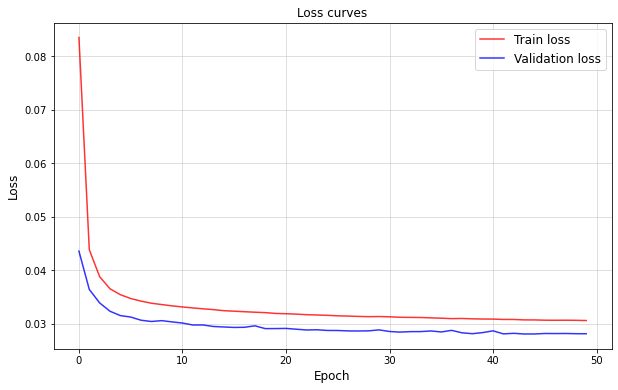

In [25]:
plt.figure(figsize=(10,6))
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [26]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:04<00:00, 2336.37it/s]


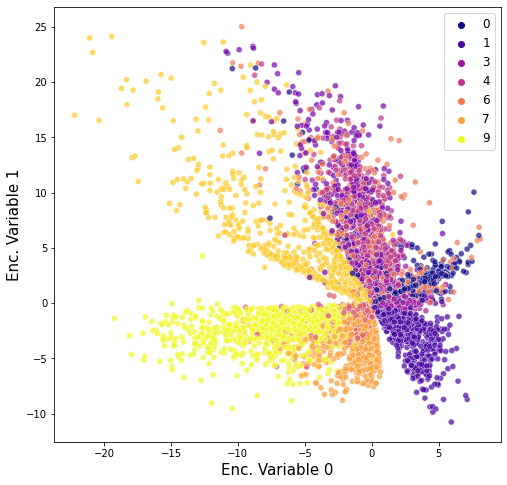

In [27]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('Enc. Variable 0', size=15)
ax.set_ylabel('Enc. Variable 1', size=15);

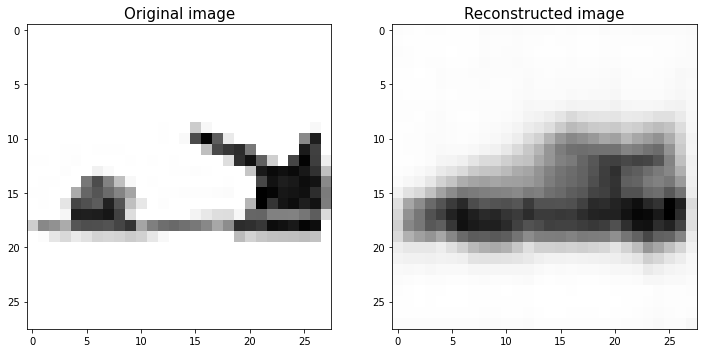

In [28]:
# Image reconstruction
idx = 1
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

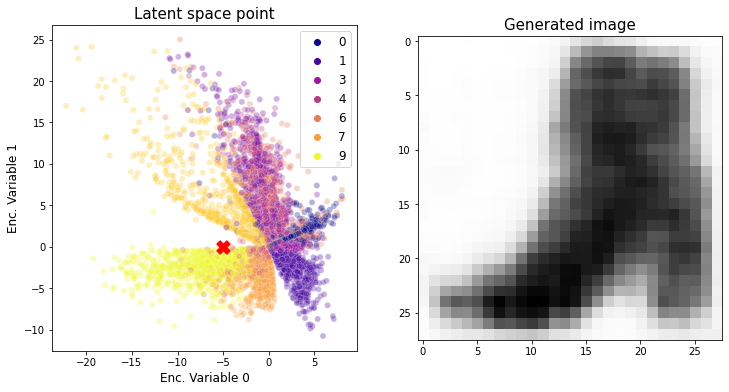

In [29]:
# Generating new images
ls_point = [-5, -0]
encoded_sample = torch.Tensor(ls_point).unsqueeze_(0).to(DEVICE)
decoder.eval()
with torch.no_grad():
    decoded_sample = decoder(encoded_sample)

encoded_sample = encoded_sample.to('cpu').squeeze().numpy()
decoded_sample = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax[0],
                alpha=0.3,
                palette='plasma')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Enc. Variable 0', size=12)
ax[0].set_ylabel('Enc. Variable 1', size=12);
ax[0].scatter(*ls_point, s=180, color='red', marker='X')
ax[0].set_title('Latent space point', size=15)
ax[1].imshow(decoded_sample, cmap='Greys')
ax[1].set_title('Generated image', size=15);

In [ ]:
# Save results
results = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results.to_csv(f'results{p_dropout}.csv')

## Optimization over the latent space dimension

In [31]:
def objective(trial):
    latent_dim = trial.suggest_int('latent space dimension', 2, 20)
    encoder = Encoder(latent_dim, 0).to(DEVICE)
    decoder = Decoder(latent_dim, 0).to(DEVICE)
    loss_fn = torch.nn.MSELoss()
    lr = 5e-4
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

    num_epochs = 5

    for epoch in range(num_epochs):
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=DEVICE, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        
        val_loss = val_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=DEVICE, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)

        print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))
    return val_loss.cpu().numpy()

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-04-01 09:40:54,575] A new study created in memory with name: no-name-4ee6d5b9-eac1-4b5a-8c3d-4fe0a3ba5d9f


EPOCH 1/5: TRAIN - loss: 0.057186 || VALIDATION - loss: 0.027426
EPOCH 2/5: TRAIN - loss: 0.024295 || VALIDATION - loss: 0.021773
EPOCH 3/5: TRAIN - loss: 0.021172 || VALIDATION - loss: 0.020280
EPOCH 4/5: TRAIN - loss: 0.020092 || VALIDATION - loss: 0.019539


[I 2022-04-01 09:41:46,523] Trial 0 finished with value: 0.01883057877421379 and parameters: {'latent space dimension': 6}. Best is trial 0 with value: 0.01883057877421379.


EPOCH 5/5: TRAIN - loss: 0.019461 || VALIDATION - loss: 0.018831
EPOCH 1/5: TRAIN - loss: 0.053201 || VALIDATION - loss: 0.027215
EPOCH 2/5: TRAIN - loss: 0.023002 || VALIDATION - loss: 0.019842
EPOCH 3/5: TRAIN - loss: 0.018842 || VALIDATION - loss: 0.017681
EPOCH 4/5: TRAIN - loss: 0.017197 || VALIDATION - loss: 0.016486


[I 2022-04-01 09:42:37,443] Trial 1 finished with value: 0.015860699117183685 and parameters: {'latent space dimension': 14}. Best is trial 1 with value: 0.015860699117183685.


EPOCH 5/5: TRAIN - loss: 0.016356 || VALIDATION - loss: 0.015861
EPOCH 1/5: TRAIN - loss: 0.075125 || VALIDATION - loss: 0.034156
EPOCH 2/5: TRAIN - loss: 0.027317 || VALIDATION - loss: 0.022914
EPOCH 3/5: TRAIN - loss: 0.020992 || VALIDATION - loss: 0.019070
EPOCH 4/5: TRAIN - loss: 0.018501 || VALIDATION - loss: 0.017683


[I 2022-04-01 09:43:27,877] Trial 2 finished with value: 0.016596052795648575 and parameters: {'latent space dimension': 14}. Best is trial 1 with value: 0.015860699117183685.


EPOCH 5/5: TRAIN - loss: 0.017196 || VALIDATION - loss: 0.016596
EPOCH 1/5: TRAIN - loss: 0.080165 || VALIDATION - loss: 0.034371
EPOCH 2/5: TRAIN - loss: 0.026055 || VALIDATION - loss: 0.021140
EPOCH 3/5: TRAIN - loss: 0.019386 || VALIDATION - loss: 0.017799
EPOCH 4/5: TRAIN - loss: 0.017272 || VALIDATION - loss: 0.016508


[I 2022-04-01 09:44:18,155] Trial 3 finished with value: 0.0155930882319808 and parameters: {'latent space dimension': 17}. Best is trial 3 with value: 0.0155930882319808.


EPOCH 5/5: TRAIN - loss: 0.016197 || VALIDATION - loss: 0.015593
EPOCH 1/5: TRAIN - loss: 0.070588 || VALIDATION - loss: 0.036763
EPOCH 2/5: TRAIN - loss: 0.030181 || VALIDATION - loss: 0.025986
EPOCH 3/5: TRAIN - loss: 0.024721 || VALIDATION - loss: 0.023417
EPOCH 4/5: TRAIN - loss: 0.022956 || VALIDATION - loss: 0.022188


[I 2022-04-01 09:45:08,145] Trial 4 finished with value: 0.02153671532869339 and parameters: {'latent space dimension': 4}. Best is trial 3 with value: 0.0155930882319808.


EPOCH 5/5: TRAIN - loss: 0.022157 || VALIDATION - loss: 0.021537
EPOCH 1/5: TRAIN - loss: 0.066667 || VALIDATION - loss: 0.031832
EPOCH 2/5: TRAIN - loss: 0.027226 || VALIDATION - loss: 0.026078
EPOCH 3/5: TRAIN - loss: 0.022731 || VALIDATION - loss: 0.021087
EPOCH 4/5: TRAIN - loss: 0.020239 || VALIDATION - loss: 0.019268


[I 2022-04-01 09:45:58,083] Trial 5 finished with value: 0.018505539745092392 and parameters: {'latent space dimension': 8}. Best is trial 3 with value: 0.0155930882319808.


EPOCH 5/5: TRAIN - loss: 0.018979 || VALIDATION - loss: 0.018506
EPOCH 1/5: TRAIN - loss: 0.074088 || VALIDATION - loss: 0.034672
EPOCH 2/5: TRAIN - loss: 0.027385 || VALIDATION - loss: 0.022562
EPOCH 3/5: TRAIN - loss: 0.021222 || VALIDATION - loss: 0.019605
EPOCH 4/5: TRAIN - loss: 0.019216 || VALIDATION - loss: 0.018331


[I 2022-04-01 09:46:48,181] Trial 6 finished with value: 0.017562026157975197 and parameters: {'latent space dimension': 8}. Best is trial 3 with value: 0.0155930882319808.


EPOCH 5/5: TRAIN - loss: 0.018189 || VALIDATION - loss: 0.017562
EPOCH 1/5: TRAIN - loss: 0.056446 || VALIDATION - loss: 0.027590
EPOCH 2/5: TRAIN - loss: 0.023393 || VALIDATION - loss: 0.020045
EPOCH 3/5: TRAIN - loss: 0.018810 || VALIDATION - loss: 0.017777
EPOCH 4/5: TRAIN - loss: 0.016783 || VALIDATION - loss: 0.016166


[I 2022-04-01 09:47:38,124] Trial 7 finished with value: 0.015126628801226616 and parameters: {'latent space dimension': 19}. Best is trial 7 with value: 0.015126628801226616.


EPOCH 5/5: TRAIN - loss: 0.015736 || VALIDATION - loss: 0.015127
EPOCH 1/5: TRAIN - loss: 0.061753 || VALIDATION - loss: 0.026111
EPOCH 2/5: TRAIN - loss: 0.021533 || VALIDATION - loss: 0.018490
EPOCH 3/5: TRAIN - loss: 0.017526 || VALIDATION - loss: 0.016611
EPOCH 4/5: TRAIN - loss: 0.015841 || VALIDATION - loss: 0.015160


[I 2022-04-01 09:48:27,896] Trial 8 finished with value: 0.014548145234584808 and parameters: {'latent space dimension': 20}. Best is trial 8 with value: 0.014548145234584808.


EPOCH 5/5: TRAIN - loss: 0.014961 || VALIDATION - loss: 0.014548
EPOCH 1/5: TRAIN - loss: 0.099431 || VALIDATION - loss: 0.037754
EPOCH 2/5: TRAIN - loss: 0.029391 || VALIDATION - loss: 0.023796
EPOCH 3/5: TRAIN - loss: 0.022087 || VALIDATION - loss: 0.020365
EPOCH 4/5: TRAIN - loss: 0.019726 || VALIDATION - loss: 0.018918


[I 2022-04-01 09:49:17,951] Trial 9 finished with value: 0.01804877072572708 and parameters: {'latent space dimension': 8}. Best is trial 8 with value: 0.014548145234584808.


EPOCH 5/5: TRAIN - loss: 0.018713 || VALIDATION - loss: 0.018049


In [33]:
best_latent_dim = study.best_params['latent space dimension']
encoder = Encoder(best_latent_dim, 0).to(DEVICE)
decoder = Decoder(best_latent_dim, 0).to(DEVICE)
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

NameError: name 'study' is not defined

In [ ]:
results_df = pd.read_csv(f'parameters/results_best.csv')
train_log = results_df['loss_curve']
val_log = results_df['val_curve']

encoder.load_state_dict(torch.load(f'parameters/encoder_best_params.pth'))
decoder.load_state_dict(torch.load(f'parameters/decoder_best_params.pth'))
encoder.eval()
decoder.eval()

In [ ]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_best_params.pth')
torch.save(decoder.state_dict(), 'decoder_best_params.pth')

EPOCH 1/50: TRAIN - loss: 0.065109 || VALIDATION - loss: 0.029775
EPOCH 2/50: TRAIN - loss: 0.024321 || VALIDATION - loss: 0.020680
EPOCH 3/50: TRAIN - loss: 0.018814 || VALIDATION - loss: 0.017322
EPOCH 4/50: TRAIN - loss: 0.016713 || VALIDATION - loss: 0.015829
EPOCH 5/50: TRAIN - loss: 0.015652 || VALIDATION - loss: 0.015077
EPOCH 6/50: TRAIN - loss: 0.014948 || VALIDATION - loss: 0.014518
EPOCH 7/50: TRAIN - loss: 0.014453 || VALIDATION - loss: 0.014087
EPOCH 8/50: TRAIN - loss: 0.014075 || VALIDATION - loss: 0.014044
EPOCH 9/50: TRAIN - loss: 0.013732 || VALIDATION - loss: 0.013473
EPOCH 10/50: TRAIN - loss: 0.013511 || VALIDATION - loss: 0.013329
EPOCH 11/50: TRAIN - loss: 0.013287 || VALIDATION - loss: 0.013154
EPOCH 12/50: TRAIN - loss: 0.013109 || VALIDATION - loss: 0.012973
EPOCH 13/50: TRAIN - loss: 0.012995 || VALIDATION - loss: 0.012947
EPOCH 14/50: TRAIN - loss: 0.012829 || VALIDATION - loss: 0.012826
EPOCH 15/50: TRAIN - loss: 0.012721 || VALIDATION - loss: 0.012912
EPOC

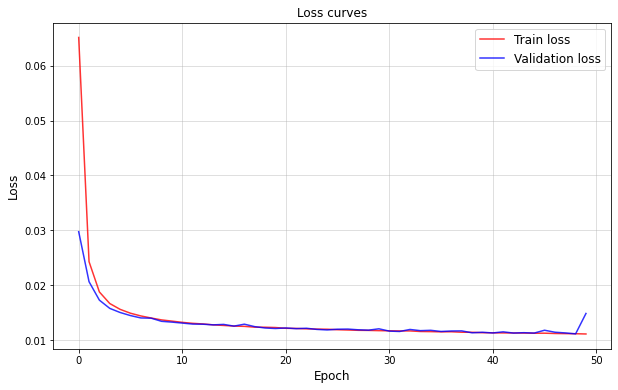

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:09<00:00, 1004.93it/s]


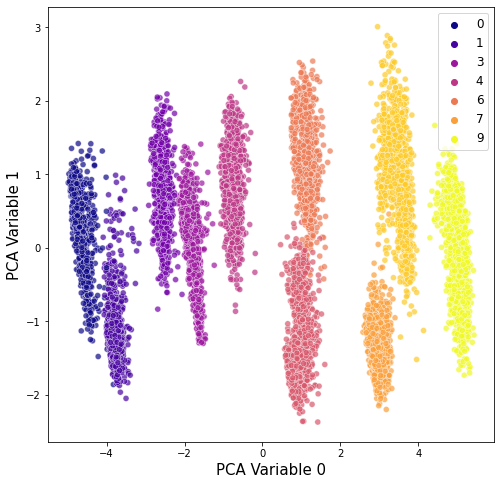

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1],
                hue=encoded_samples.label.to_numpy(),
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('PCA Variable 0', size=15)
ax.set_ylabel('PCA Variable 1', size=15);

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

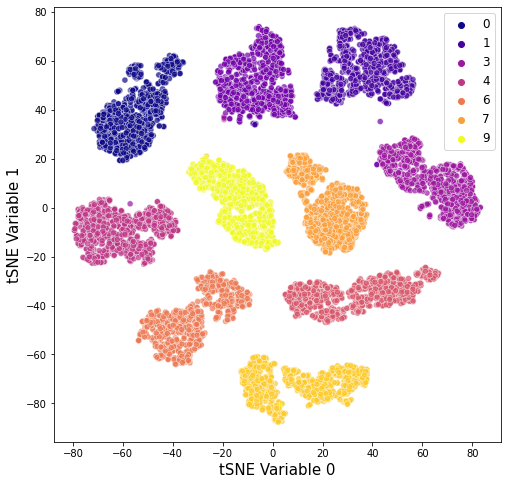

In [ ]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1],
                hue=encoded_samples.label.to_numpy(),
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('tSNE Variable 0', size=15)
ax.set_ylabel('tSNE Variable 1', size=15);

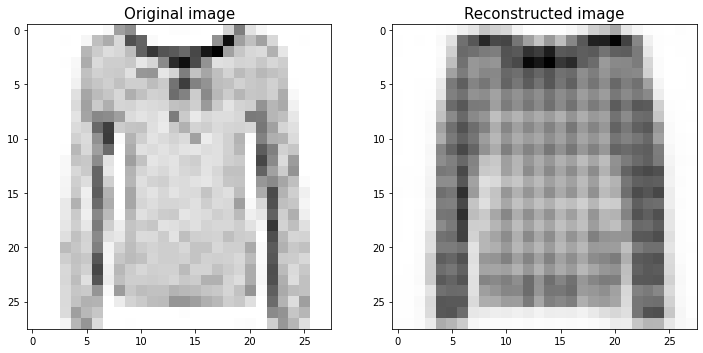

In [ ]:
# Image reconstruction
idx = 0
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

In [ ]:
# Save results
results = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results.to_csv('results_best.csv')

## Classification task

In [14]:
best_latent_dim = 20
encoder = Encoder(best_latent_dim, 0)
encoder.load_state_dict(torch.load('parameters/encoder_best_params.pth'))
encoder.to(DEVICE)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_fc): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=20, bias=True)
  )
)

In [21]:
class Classifier_net(nn.Module):
    """
    Three layers fc network
    """

    def __init__(self, params):
        super().__init__()
        self.fc0 = nn.Linear(in_features=params['latent_space_dimension'],
                             out_features=params['features_fc0'])
        self.fc1 = nn.Linear(in_features=params['features_fc0'],
                             out_features=params['features_fc1'])
        self.fc2 = nn.Linear(in_features=params['features_fc1'],
                             out_features=10)
        self.dropout = nn.Dropout(params['p_dropout'])
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [32]:
def train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, device, dataloader):
    train_loss = []
    classifier_net.train()
    for sample_batch in dataloader:
        image_batch = sample_batch[0].to(device)
        label_batch = sample_batch[1].to(device)
        encoded_image = encoder(image_batch)
        classifier_output = classifier_net(encoded_image)
        loss = loss_fn(classifier_output, label_batch)
        classifier_net.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch_classifier(encoder, classifier_net, loss_fn, device, dataloader):
    val_loss = []
    correct = 0
    total = 0
    classifier_net.eval()
    with torch.no_grad():
        for sample_batch in dataloader:
            image_batch = sample_batch[0].to(device)
            label_batch = sample_batch[1].to(device)
            encoded_image = encoder(image_batch)
            classifier_output = classifier_net(encoded_image)
            _, predicted = torch.max(classifier_output.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
            loss = loss_fn(classifier_output, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    accuracy = 100 * correct / total
    return np.mean(val_loss), accuracy

In [37]:
def objective(trial):
    params = {
        'latent_space_dimension' : best_latent_dim,
        'features_fc0' : trial.suggest_int('features_fc0', 64, 256),
        'features_fc1' : trial.suggest_int('features_fc1', 32, 64),
        'p_dropout' : trial.suggest_float('p_dropout', 0., 0.2)
    }

    classifier_net = Classifier_net(params).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier_net.parameters(), lr=1e-3)
    
    num_epochs = 5
    for epoch in range(num_epochs):
        _ = train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, DEVICE, train_dataloader)
        _, accuracy = val_epoch_classifier(encoder, classifier_net, loss_fn, DEVICE, val_dataloader)
        print('EPOCH {:}/{:} - val accuracy: {:.2f}'.format(epoch+1, num_epochs, accuracy))
    
    return accuracy

In [38]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-04-02 09:51:46,193] A new study created in memory with name: no-name-1b4776ce-f83b-4771-9bcb-ca01ed204cbe


EPOCH 1/5 - val accuracy: 80.67
EPOCH 2/5 - val accuracy: 82.62
EPOCH 3/5 - val accuracy: 83.78
EPOCH 4/5 - val accuracy: 84.21


[I 2022-04-02 09:52:25,771] Trial 0 finished with value: 84.93 and parameters: {'features_fc0': 189, 'features_fc1': 57, 'p_dropout': 0.1585950164487998}. Best is trial 0 with value: 84.93.


EPOCH 5/5 - val accuracy: 84.93
EPOCH 1/5 - val accuracy: 80.48
EPOCH 2/5 - val accuracy: 82.83
EPOCH 3/5 - val accuracy: 83.97
EPOCH 4/5 - val accuracy: 84.45


[I 2022-04-02 09:53:05,904] Trial 1 finished with value: 84.93 and parameters: {'features_fc0': 209, 'features_fc1': 60, 'p_dropout': 0.17228057621988663}. Best is trial 0 with value: 84.93.


EPOCH 5/5 - val accuracy: 84.93
EPOCH 1/5 - val accuracy: 80.23
EPOCH 2/5 - val accuracy: 82.63
EPOCH 3/5 - val accuracy: 83.73
EPOCH 4/5 - val accuracy: 84.35


[I 2022-04-02 09:53:45,222] Trial 2 finished with value: 84.97 and parameters: {'features_fc0': 195, 'features_fc1': 45, 'p_dropout': 0.07036858590259963}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.97
EPOCH 1/5 - val accuracy: 80.12
EPOCH 2/5 - val accuracy: 83.16
EPOCH 3/5 - val accuracy: 83.92
EPOCH 4/5 - val accuracy: 84.38


[I 2022-04-02 09:54:25,025] Trial 3 finished with value: 84.62 and parameters: {'features_fc0': 180, 'features_fc1': 56, 'p_dropout': 0.031202570573592214}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.62
EPOCH 1/5 - val accuracy: 79.01
EPOCH 2/5 - val accuracy: 81.73
EPOCH 3/5 - val accuracy: 82.62
EPOCH 4/5 - val accuracy: 83.81


[I 2022-04-02 09:55:05,007] Trial 4 finished with value: 84.38 and parameters: {'features_fc0': 91, 'features_fc1': 39, 'p_dropout': 0.05390875538605262}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.38
EPOCH 1/5 - val accuracy: 79.48
EPOCH 2/5 - val accuracy: 81.95
EPOCH 3/5 - val accuracy: 83.05
EPOCH 4/5 - val accuracy: 83.63


[I 2022-04-02 09:55:44,746] Trial 5 finished with value: 83.99 and parameters: {'features_fc0': 96, 'features_fc1': 47, 'p_dropout': 0.008774233752111482}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 83.99
EPOCH 1/5 - val accuracy: 79.00
EPOCH 2/5 - val accuracy: 82.41
EPOCH 3/5 - val accuracy: 83.45
EPOCH 4/5 - val accuracy: 83.94


[I 2022-04-02 09:56:24,898] Trial 6 finished with value: 84.68 and parameters: {'features_fc0': 184, 'features_fc1': 49, 'p_dropout': 0.12286322797962056}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.68
EPOCH 1/5 - val accuracy: 80.09
EPOCH 2/5 - val accuracy: 81.57
EPOCH 3/5 - val accuracy: 83.33
EPOCH 4/5 - val accuracy: 84.00


[I 2022-04-02 09:57:04,437] Trial 7 finished with value: 84.39 and parameters: {'features_fc0': 165, 'features_fc1': 33, 'p_dropout': 0.03316331864931626}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.39
EPOCH 1/5 - val accuracy: 79.80
EPOCH 2/5 - val accuracy: 82.03
EPOCH 3/5 - val accuracy: 83.33
EPOCH 4/5 - val accuracy: 83.75


[I 2022-04-02 09:57:43,099] Trial 8 finished with value: 84.24 and parameters: {'features_fc0': 198, 'features_fc1': 33, 'p_dropout': 0.18956141366821183}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.24
EPOCH 1/5 - val accuracy: 79.99
EPOCH 2/5 - val accuracy: 82.30
EPOCH 3/5 - val accuracy: 83.63
EPOCH 4/5 - val accuracy: 84.27


[I 2022-04-02 09:58:22,536] Trial 9 finished with value: 84.95 and parameters: {'features_fc0': 157, 'features_fc1': 49, 'p_dropout': 0.06824540560222421}. Best is trial 2 with value: 84.97.


EPOCH 5/5 - val accuracy: 84.95


In [40]:
best_params = study.best_params.copy()
best_params['latent_space_dimension'] = best_latent_dim

In [41]:
classifier_net = Classifier_net(best_params).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_net.parameters(), lr=1e-3)

num_epochs = 50
log_train = []
log_val = []
log_accuracy = []
for epoch in range(num_epochs):
    train_loss = train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, DEVICE, train_dataloader)
    val_loss, accuracy = val_epoch_classifier(encoder, classifier_net, loss_fn, DEVICE, val_dataloader)
    log_train.append(train_loss)
    log_val.append(val_loss)
    log_accuracy.append(accuracy)
    print('EPOCH {:}/{:} - val accuracy: {:.2f}'.format(epoch+1, num_epochs, accuracy))

EPOCH 1/50 - val accuracy: 80.08
EPOCH 2/50 - val accuracy: 82.72
EPOCH 3/50 - val accuracy: 83.33
EPOCH 4/50 - val accuracy: 84.35
EPOCH 5/50 - val accuracy: 84.86
EPOCH 6/50 - val accuracy: 85.27
EPOCH 7/50 - val accuracy: 85.42
EPOCH 8/50 - val accuracy: 85.81
EPOCH 9/50 - val accuracy: 86.10
EPOCH 10/50 - val accuracy: 86.06
EPOCH 11/50 - val accuracy: 86.54
EPOCH 12/50 - val accuracy: 86.69
EPOCH 13/50 - val accuracy: 86.35
EPOCH 14/50 - val accuracy: 86.93
EPOCH 15/50 - val accuracy: 86.82
EPOCH 16/50 - val accuracy: 87.07
EPOCH 17/50 - val accuracy: 86.87
EPOCH 18/50 - val accuracy: 86.89
EPOCH 19/50 - val accuracy: 87.09
EPOCH 20/50 - val accuracy: 87.14
EPOCH 21/50 - val accuracy: 87.19
EPOCH 22/50 - val accuracy: 87.41
EPOCH 23/50 - val accuracy: 87.34
EPOCH 24/50 - val accuracy: 87.52
EPOCH 25/50 - val accuracy: 87.65
EPOCH 26/50 - val accuracy: 87.73
EPOCH 27/50 - val accuracy: 87.68
EPOCH 28/50 - val accuracy: 87.65
EPOCH 29/50 - val accuracy: 87.57
EPOCH 30/50 - val accur

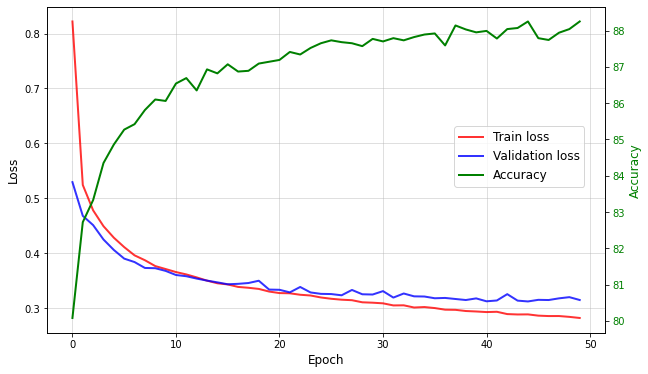

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(log_train, c='red', label='Train loss', alpha=0.8, lw=2)
ax.plot(log_val, c='blue', label='Validation loss', alpha=0.8, lw=2)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.grid(alpha=0.5)

ax2 = ax.twinx()
ax2.plot(log_accuracy, label='Accuracy', lw=2, c='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('Accuracy', size=12, c='green')

fig.legend(loc=(0.7, 0.5), fontsize=12);